<a href="https://colab.research.google.com/github/wasanahere/qcomp/blob/main/QAOA_MaxCut_RegularGraph.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!python -m pip install pennylane pennylane-lightning pennylane-lightning-gpu --upgrade
!pip install custatevec-cu12

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.1/56.1 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 33.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 37.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 28.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 930.0/930.0 kB 41.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 35.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 37.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.6/38.6 MB 13.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 167.9/167.9 kB 5.3 MB/s eta 0:00:00


In [3]:
# Import statements
import pennylane as qml
from pennylane import qaoa
from pennylane import numpy as np
from matplotlib import pyplot as plt
import networkx as nx
import time

SEED = 420

In [26]:
def qaoa_maxcut(g, depth, updates=30):
    cost_h, mixer_h = qaoa.maxcut(g)

    def qaoa_layer(gamma, beta):
        qaoa.cost_layer(gamma, cost_h)
        qaoa.mixer_layer(beta, mixer_h)

    wires = range(g.order())

    def circuit(ps):
        for w in wires:
            qml.Hadamard(wires=w)
        qml.layer(qaoa_layer, depth, ps[0], ps[1])

    dev = qml.device("lightning.gpu", wires=wires)

    @qml.qnode(dev)
    def cost_function(ps):
        circuit(ps)
        return qml.expval(cost_h)

    optimizer = qml.AdagradOptimizer(stepsize=0.5)
    init_params = 0.01 * np.random.rand(2, depth, requires_grad=True)
    params = init_params.copy()
    costs = []
    for i in range(updates):
        params = optimizer.step(cost_function, params)
        costs.append(-cost_function(params))

    @qml.qnode(dev)
    def probability_circuit(gamma, alpha):
        circuit([gamma, alpha])
        return qml.probs(wires=wires)

    probs = probability_circuit(params[0], params[1])

    true_cost = -qml.eigvals(cost_h)[0]

    return true_cost, costs, probs, params

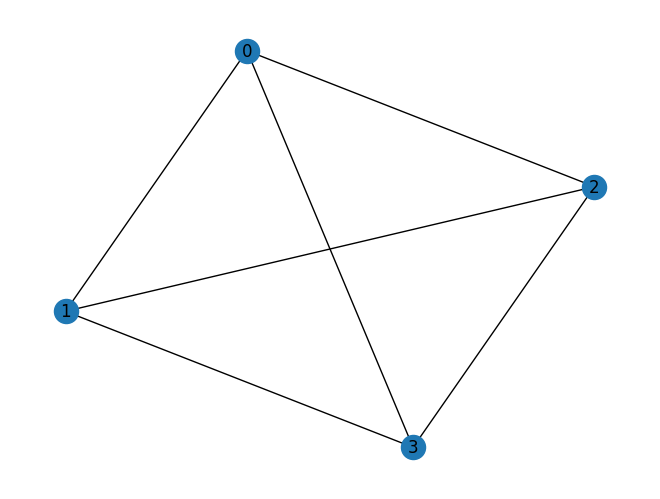

In [43]:
n = 4
example = nx.random_regular_graph(3, n)
positions = nx.spring_layout(example, seed=SEED)
nx.draw(example, with_labels=True, pos=positions)

In [96]:
min_p = 1
max_p = 2
ps = range(min_p, max_p + 1)
steps = 70
results = []
for p in ps:
    result = qaoa_maxcut(example, p, steps)
    results.append(result)

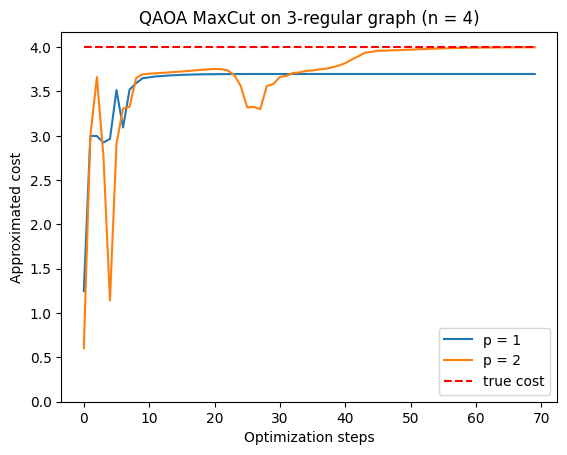

In [106]:
plt.title(f"QAOA MaxCut on 3-regular graph (n = {n})")
for i, p in enumerate(ps):
    plt.plot(range(steps), results[i][1], "-", label=f"p = {p}", markersize=1)
plt.plot(range(steps), [results[0][0]] * steps, "r--", label="true cost")
plt.legend()
plt.xlabel("Optimization steps")
plt.ylabel("Approximated cost")
plt.ylim(ymin=0)
plt.show()

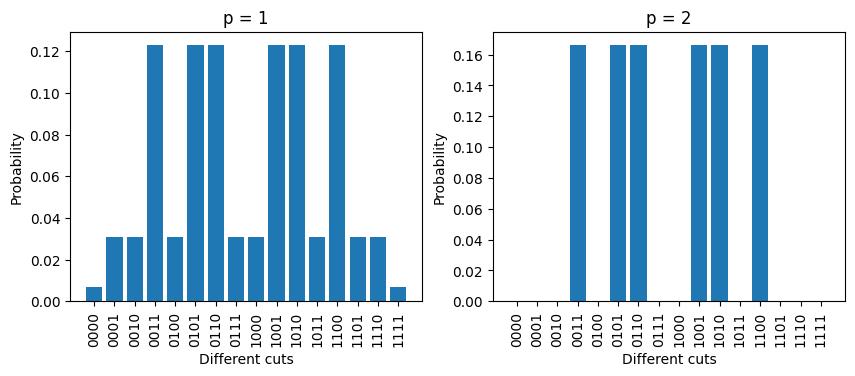

In [103]:
options = 2 ** n
bitstrings = list(map(lambda x: format(x, "04b"), range(options)))
fig, _ = plt.subplots(1, len(ps), figsize=(10, 3.5))
for i, p in enumerate(ps):
    plt.subplot(1, len(ps), i + 1)
    plt.title(f"p = {p}")
    plt.bar(range(options), results[i][2])
    plt.xticks(range(options), bitstrings, rotation='vertical')
    plt.xlabel("Different cuts")
    plt.ylabel("Probability")
plt.show()

In [ ]:
min_p = 1
max_p = 10
ps = range(min_p, max_p + 1)
samples = 10
ns = range(6, 13, 2)


results = {}
for p in ps:
    results[f"{p}"]
    for n in ns:
        graphs = [nx.random_regular_graph(3, n) for _ in range(samples)]
        result = []
        for graph in graphs:
            true_cost, costs, _, _ = qaoa_maxcut()

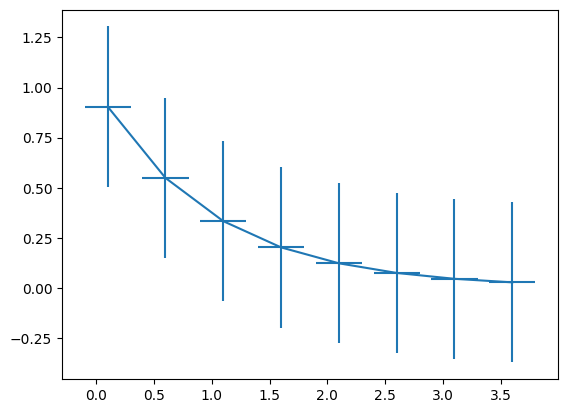

In [107]:
x = np.arange(0.1, 4, 0.5)
y = np.exp(-x)

fig, ax = plt.subplots()
ax.errorbar(x, y, xerr=0.2, yerr=0.4)
plt.show()

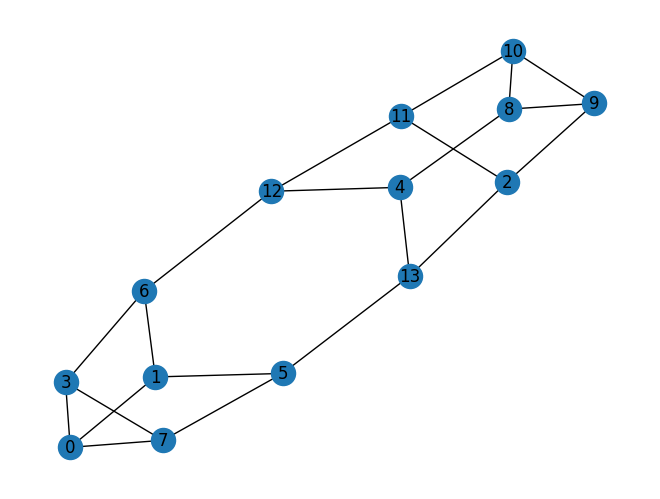

In [118]:
example = nx.random_regular_graph(3, 14)
positions = nx.spring_layout(example, seed=SEED)
nx.draw(example, with_labels=True, pos=positions)